In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/OCR-pipeline/vietnamese-ocr

/content/drive/MyDrive/OCR-pipeline/vietnamese-ocr


In [ ]:
!pip install -q -r requirement.txt

In [ ]:
!pip install -q paddleocr
!pip install -q paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.7/465.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 112.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb

--2023-09-28 06:54:35--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 91.189.91.81, 185.125.190.36, 91.189.91.82, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|91.189.91.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1321244 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  2.53MB/s    in 0.5s    

2023-09-28 06:54:36 (2.53 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb’ saved [1321244/1321244]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.19) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.19) ...
debconf: unable to initialize fronten

In [ ]:
import paddleocr

# Importing

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.vietocr.tool.predictor import Predictor
from vietocr.vietocr.tool.config import Cfg

from PaddleOCR import PaddleOCR, draw_ocr

# Ultilities

In [ ]:
FONT = './PaddleOCR/doc/fonts/latin.ttf'
def predict(recognitor, detector, img_path, save_path, padding=4, dpi=100):
    # Load image
    img = cv2.imread(img_path)

    # Text detection
    result = detector.ocr(img_path, cls=False, det=True, rec=False)
    result = result[:][:][0]

    # Filter Boxes
    boxes = []
    for line in result:
        boxes.append([[int(line[0][0]), int(line[0][1])], [int(line[2][0]), int(line[2][1])]])
    boxes = boxes[::-1]

    # Add padding to boxes
    padding = 4
    for box in boxes:
        box[0][0] = box[0][0] - padding
        box[0][1] = box[0][1] - padding
        box[1][0] = box[1][0] + padding
        box[1][1] = box[1][1] + padding

    # Text recognizion
    texts = []
    for box in boxes:
        cropped_image = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        try:
            cropped_image = Image.fromarray(cropped_image)
        except:
            continue

        rec_result = recognitor.predict(cropped_image)

        text = rec_result#[0]

        texts.append(text)
        #print(text)

    # Convert boxes to draw
    def get_rectangle_points(x1, y1, x2, y2):
        x_tl = x1
        y_tl = y2
        x_br = x2
        y_br = y1
        return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    _boxes = [get_rectangle_points(boxe[0][0], boxe[0][1], boxe[1][0], boxe[1][1]) for boxe in boxes]

    # Draw boxes and texts
    img = draw_ocr(img, _boxes, texts, scores=None, font_path=FONT)


    # Save image
    img_name = img_path.split('/')[-1]
    cv2.imwrite(os.path.join(save_path, img_name), img)

    # Display image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    height, width, depth = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray')

    plt.show()

    return boxes, texts

def display_image_in_actual_size(img_path, dpi=200):
  im_data = cv2.imread(img_path)

  height, width, depth = im_data.shape

  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure of the right size with one axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc.
  ax.axis('off')

  # Display the image.
  ax.imshow(im_data, cmap='gray')

  plt.show()

# Configuration

In [ ]:
# Config of PaddleOCR
detector = PaddleOCR(use_angle_cls=False, lang="vi", use_gpu=True)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:02<00:00, 1.69MiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/latin_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer/latin_PP-OCRv3_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:15<00:00, 643kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:11<00:00, 198kiB/s]

[2023/09/28 06:55:35] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_

In [ ]:
# Configure of VietOCR
config = Cfg.load_config_from_name('vgg_transformer')
# config = Cfg.load_config_from_file('vietocr/config.yml')
# config['weights'] = 'transformer.pth'

config['cnn']['pretrained'] = True
config['predictor']['beamsearch'] = True
config['device'] = 'cuda:0' # mps

recognitor = Predictor(config)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:04<00:00, 134MB/s]
18533it [00:09, 1922.97it/s]


# Only VietOCR

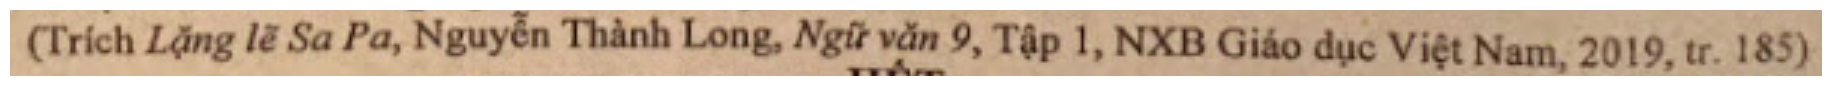

'(Trích Lặng lẽ Sa Pa, Nguyễn Thành Long, Ngữ văn 9, Tập 1, NXB Giáo dục Việt Nam, 2019, tr.185)'

In [ ]:
img_path = 'samples/devan4.png'

img = cv2.imread(img_path)
img = Image.fromarray(img)
rec_result = recognitor.predict(img)

display_image_in_actual_size(img_path, dpi=100)

rec_result

# Paddle + VietOCR

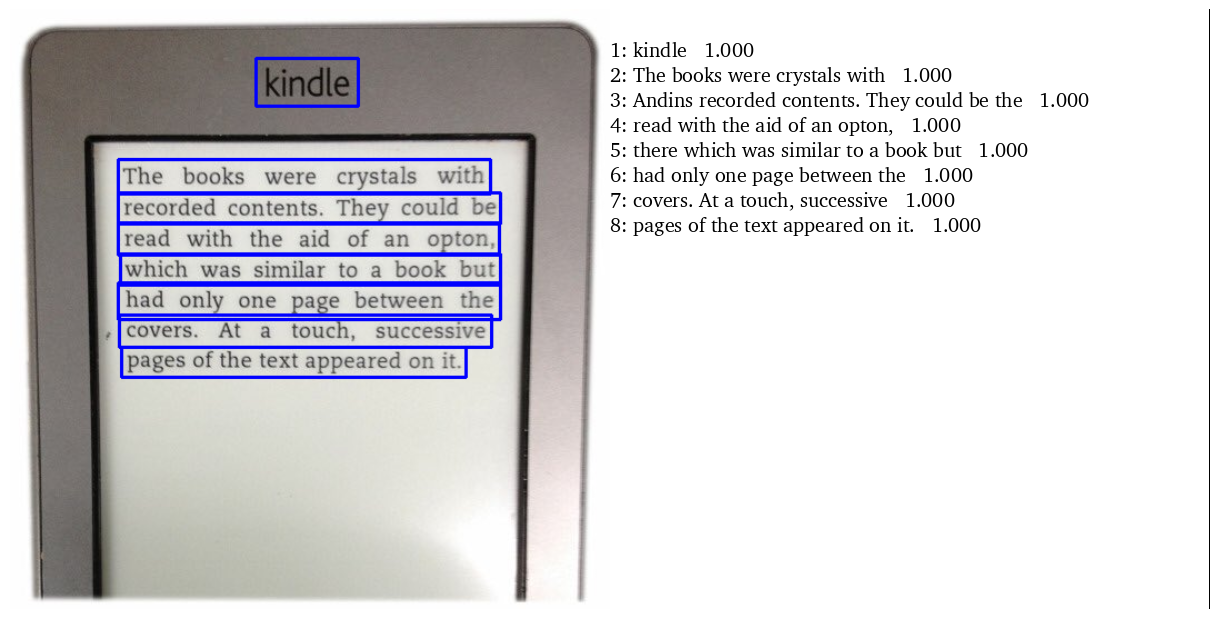

In [ ]:
input_path = 'samples/kindle_english.jpg'
output_path = './output'

# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)